In [1]:
# improts
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import re
from pathlib import Path
from glob import glob
import pickle
import shutil
import json
import io
import pandas as pd
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
from rdkit.Chem.rdMolDescriptors import CalcNumRotatableBonds
import py3Dmol
import copy

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

import pickle
from support_mvp.backup_plot_diagram.data_handler import renamed_load

# For highlight colors
from matplotlib.colors import ColorConverter
import matplotlib.ticker as mticker

# Stuff for changing rdkit drawing view: 
#IPythonConsole.drawOptions.addAtomIndices = True
#IPythonConsole.molSize = 500,500
#IPythonConsole.drawOptions.addAtomIndices = True

font = {'weight' : 'bold',
        'size'   : 12}
plt.rc('font', **font)

HARTREE2EV = 27.2114
HARTREE2KCAL = 627.51
kcal = 627.51
ev = 27.2114


# Alternate way 
#with open('benzene.svg','w') as f:
#    f.write(img.data)
#img = Chem.Draw.MolsToGridImage([m], useSVG=True)
    

In [2]:
dft_base = Path('/home/magstr/dft_data')
img_dir = Path('imgs')

### Functions

In [3]:
def draw_mol(
    mol,
    width=900,
    height=900,
    Hs=False,
    confId=-1,
    multipleConfs=False,
    atomlabel=False,
    hit_ats=None,
    gen_struct=None,
    trajectory=False,
):
    p = py3Dmol.view(width=width, height=height)
    
    if isinstance(mol, str):
        xyz_f = open(mol)
        line = xyz_f.read()
        xyz_f.close()
        p.addModel(line, "xyz")
    else:
        if multipleConfs:
            for conf in mol.GetConformers():
                mb = Chem.MolToMolBlock(mol, confId=conf.GetId())
                p.addModel(mb, "sdf")
        else:
            mb = Chem.MolToMolBlock(mol)
            p.addModel(mb, "sdf")
        
    p.setStyle({"stick": {"radius": 0.2}, "sphere":
                {"radius": 0.3}})
    if atomlabel:
        p.addPropertyLabels("index")  # ,{'elem':'H'}
    p.zoomTo()
    p.update()

In [4]:
def single_atom_remover(mol, idx):
    """Function that removes an atom at specified idx.

    Args:
        mol (Chem.rdchem.Mol): The mol to remove substruct on
        pattern (Chem.rdchem.Mol): mol object to remove from the input mol

    Returns:
        Chem.rdchem.Mol: The ouput mol with the atom removed
    """
    res = Chem.RWMol(mol)
    res.BeginBatchEdit()
    res.RemoveAtom(idx)
    res.CommitBatchEdit()
    Chem.SanitizeMol(res)
    return res.GetMol()

In [5]:
def remove_NH3(mol):
    """Remove NH3 group on mol."""

    # Substructure match the NH3
    NH3_match = Chem.MolFromSmarts("[NH3]")
    NH3_match = Chem.AddHs(NH3_match)
    removed_mol = Chem.DeleteSubstructs(mol, NH3_match)

    return removed_mol

## Core images

In [20]:
conformer_file = Path('../data/final_dft_opt.pkl')

with open(conformer_file, "rb") as f:
    conf = pickle.load(f)
conf.sortby('final_dft_opt')

In [7]:
for i in range(len(conf.molecules)):
    print(conf.molecules[i].smiles, i)

Nc1c(F)c([O-])cc([O-])c1Br 0
Nc1c(F)c([O-])cc([O-])c1Cl 1
Nc1cc([O-])c(F)c([O-])c1F 2
Nc1cc([O-])cc([O-])c1F 3
Nc1c(F)c([O-])cc([O-])c1F 4
N#Cc1cnc(C#N)c(N)c1 5
CCNC(N)CCF 6
N#Cc1ncc(C(=O)CO)cc1N 7
CNC(N)Cc1ccccc1 8
CNCCC1(N)CCCCC1 9
N#Cc1ncc(CC(=O)O)cc1N 10
CCC(N)CNc1cccc(S)c1 11
NC(CC(=S)C=O)c1cccc(F)c1 12
CCCOC(=O)NCC1(N)CCCCC1 13
CCCCN1CCCC(N)(C2CCCC2)C1 14
CC(N)Cc1ccc(Sc2ccccc2)cc1 15
CC(C)(N)CCC1CCCCC1 16
Nc1ccc(F)c(C(=O)C(=O)C(=O)Cl)c1 17
NC1(CCCCCl)CCCCC1 18
CCCN1CCCC(N)(C2CCCC2)C1 19
CCC(C)(C)CC(C)(C)N 20
CC(N)Cc1ccc(Cc2ccccc2)cc1 21
Nc1ccccc1N=CC(=O)Cl 22
C=C(C)CC(C)(C)N 23
Nc1cc(C=O)c(C=O)cc1C=O 24
CC(N)Cc1ccc(CCl)cc1 25
CC(N)CCc1ccc(-c2ccccc2)cc1 26
CC(C)CC(C)N 27
CC(C)CC(C)(C)C(C)(C)N 28
Nc1ccc(F)cc1C(=O)C(F)=S 29
CC(N)Cc1ccccc1 30
Cc1ccc(CCCC(C)N)cc1 31
C=C(C)CCCC(C)N 32
Cc1ccc(CC(C)N)cc1 33
CCCCN1CCCC(N)(C2CCC2)C1 34
Nc1cccc(C(=O)C(=O)Br)n1 35
Cc1ccccc1C(C)CC(C)N 36
NC(O)CCCC1CCCCC1 37
CCCCC(N)CC 38
CCCC(C)CC(C)N 39
N#Cc1ccnc(C(=O)Cl)c1N 40
CC(C)(N)CCCC1CC1 41
CCCCC(C)C1

In [8]:
# My candidate molecules so far
#-6  C2
#7 C3
#23 C1
# 5 C8
# 90 C9

# 119 C4

In [9]:
idx = 119

In [10]:
conf.molecules[idx].scoring_function

'rdkit_embed_scoring'

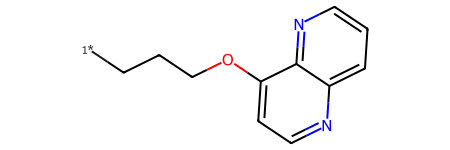

In [11]:
# Replace tricky primary amines in the frag:
prim_match = Chem.MolFromSmarts("[NX3;H2]")
rm = Chem.ReplaceSubstructs(
                            conf.molecules[idx].rdkit_mol,
                            prim_match,
                            Chem.MolFromSmiles("[1*]"),
                            replaceAll=True,
                        )[0]
rm

In [12]:
Chem.Draw.MolToFile(rm, img_dir/'tmp.svg')

In [13]:
rms = AllChem.ReplaceSubstructs(conf.molecules[idx].optimized_mol1,Chem.AddHs(Chem.MolFromSmarts('[NH3]')),Chem.MolFromSmiles('[1*]'))

In [14]:
removed = remove_NH3(conf.molecules[idx].optimized_mol1)

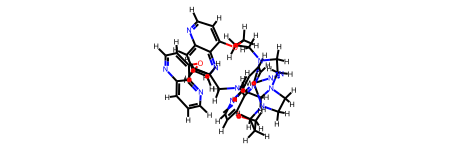

In [15]:
removed

In [16]:
#draw_mol(conf.molecules[idx].optimized_mol1,atomlabel=False)
#draw_mol(removed, atomlabel=False)

In [17]:
draw_mol(conf.molecules[idx].optimized_mol1)
draw_mol(conf.molecules[idx].optimized_mol2)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# Conformer overlay

In [63]:
# Path to folder with GA.pkl files
# What GA to look at 
gen  = '../data/final_dft_opt.pkl'

# How many molecules in the pop to look at 
size = 1

In [64]:
with open(gen, "rb") as f:
    gen = pickle.load(f)

In [65]:
#38, 57
ids=57

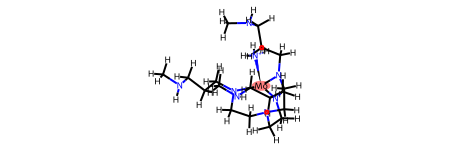

In [66]:
gen.molecules[ids].optimized_mol1

In [67]:
mol = gen.molecules[ids].optimized_mol1

In [68]:
energies = gen.molecules[ids].energy_dict['energy1']

In [69]:
def energy_filter(confs, energies, optimized_mol):

    mask = energies < (energies.min() + 0.0045)
    print(mask, energies)
    confs = list(np.array(confs)[mask])
    new_mol = copy.deepcopy(optimized_mol)
    new_mol.RemoveAllConformers()
    for c in confs:
        new_mol.AddConformer(c, assignId=True)
    energies = energies[mask]

    return energies, new_mol

In [70]:
en,new_mol = energy_filter(mol.GetConformers(), energies, mol)

[False False False False False False False False False False False False
 False False False False False  True  True False False False False False
 False False False False False False False False False False  True False
 False False False False False False False False False False False False
 False] [-87.0250331  -87.02487527 -87.0225808  -87.02410717 -87.02163529
 -87.02204507 -87.0193509  -87.02539576 -87.02369436 -87.0303681
 -87.02290432 -87.02169373 -87.02605542 -87.02993337 -87.02101709
 -87.02118    -87.02593943 -87.03524604 -87.0312599  -87.02994198
 -87.02162392 -87.01964614 -87.020262   -87.02899505 -87.02438422
 -87.02824315 -87.02212639 -87.02966549 -87.02182174 -87.02066856
 -87.02192018 -87.02587768 -87.02564603 -87.02781733 -87.03178027
 -87.02975027 -87.02060595 -87.02458898 -87.0228437  -87.02413772
 -87.02480687 -87.02051111 -87.02691091 -87.02490315 -87.02394053
 -87.02201383 -87.02060587 -87.02143232 -87.02596743]


In [73]:
#,0,6,8,3,13,10,14, 9, 2, 4, 23, 24, 25, 26, 5
AllChem.AlignMolConformers(new_mol, atomIds=[7, 0, 6, 8, 3])

In [75]:
draw_mol(new_mol,multipleConfs=True)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [121]:
#a = p.png()

## Benzene thing for illustration

In [17]:
conformer_file = Path('GA06.pkl')

with open(conformer_file, "rb") as f:
    gen = pickle.load(f)

In [18]:
m = gen.new_molecules[22].rdkit_mol

In [19]:
draw_mol(m)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol